Deformetrica API demo
----------------------------
Welcome to Deformetrica's API demo.

In this notebook we will go through several steps ranging from the setup of Deformetrica using conda, to running a [deterministic atlas](https://gitlab.com/icm-institute/aramislab/deformetrica/wikis/2_tutorials/2.2_deterministic_atlas) on 2D meshes. Finally, we will plot the resulting output using matplotlib.

You can also view the [wiki](https://gitlab.com/icm-institute/aramislab/deformetrica/wikis/home) for more information.


Please note that the first cell (Environment setup) can take up to 15 minutes to run. This is due to the shared nature of Google Colab.

In [ ]:
!git clone git@gitlab.com:icm-institute/aramislab/deformetrica.git

In [6]:
data_path = "deformetrica/examples/"
!tree -L 6 -I *.xml deformetrica/examples/

deformetrica/examples/
├── atlas
│   ├── image
│   │   └── 2d
│   │       ├── digits
│   │       │   └── data
│   │       │       ├── digit_2_mean.png
│   │       │       ├── digit_2_sample_10.png
│   │       │       ├── digit_2_sample_11.png
│   │       │       ├── digit_2_sample_12.png
│   │       │       ├── digit_2_sample_13.png
│   │       │       ├── digit_2_sample_14.png
│   │       │       ├── digit_2_sample_15.png
│   │       │       ├── digit_2_sample_16.png
│   │       │       ├── digit_2_sample_17.png
│   │       │       ├── digit_2_sample_18.png
│   │       │       ├── digit_2_sample_19.png
│   │       │       ├── digit_2_sample_1.png
│   │       │       ├── digit_2_sample_20.png
│   │       │       ├── digit_2_sample_2.png
│   │       │       ├── digit_2_sample_3.png
│   │       │       ├── digit_2_sample_4.png
│   │       │       ├── digit_2_sample_5.png
│   │       │       ├── digit_2_sample_6.png
│   │       │       ├── digit_2_sample_7.png
│   │       │       ├── digi

# Explore the data

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/fmatzkin/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/fmatzkin/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/fmatzkin/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', va

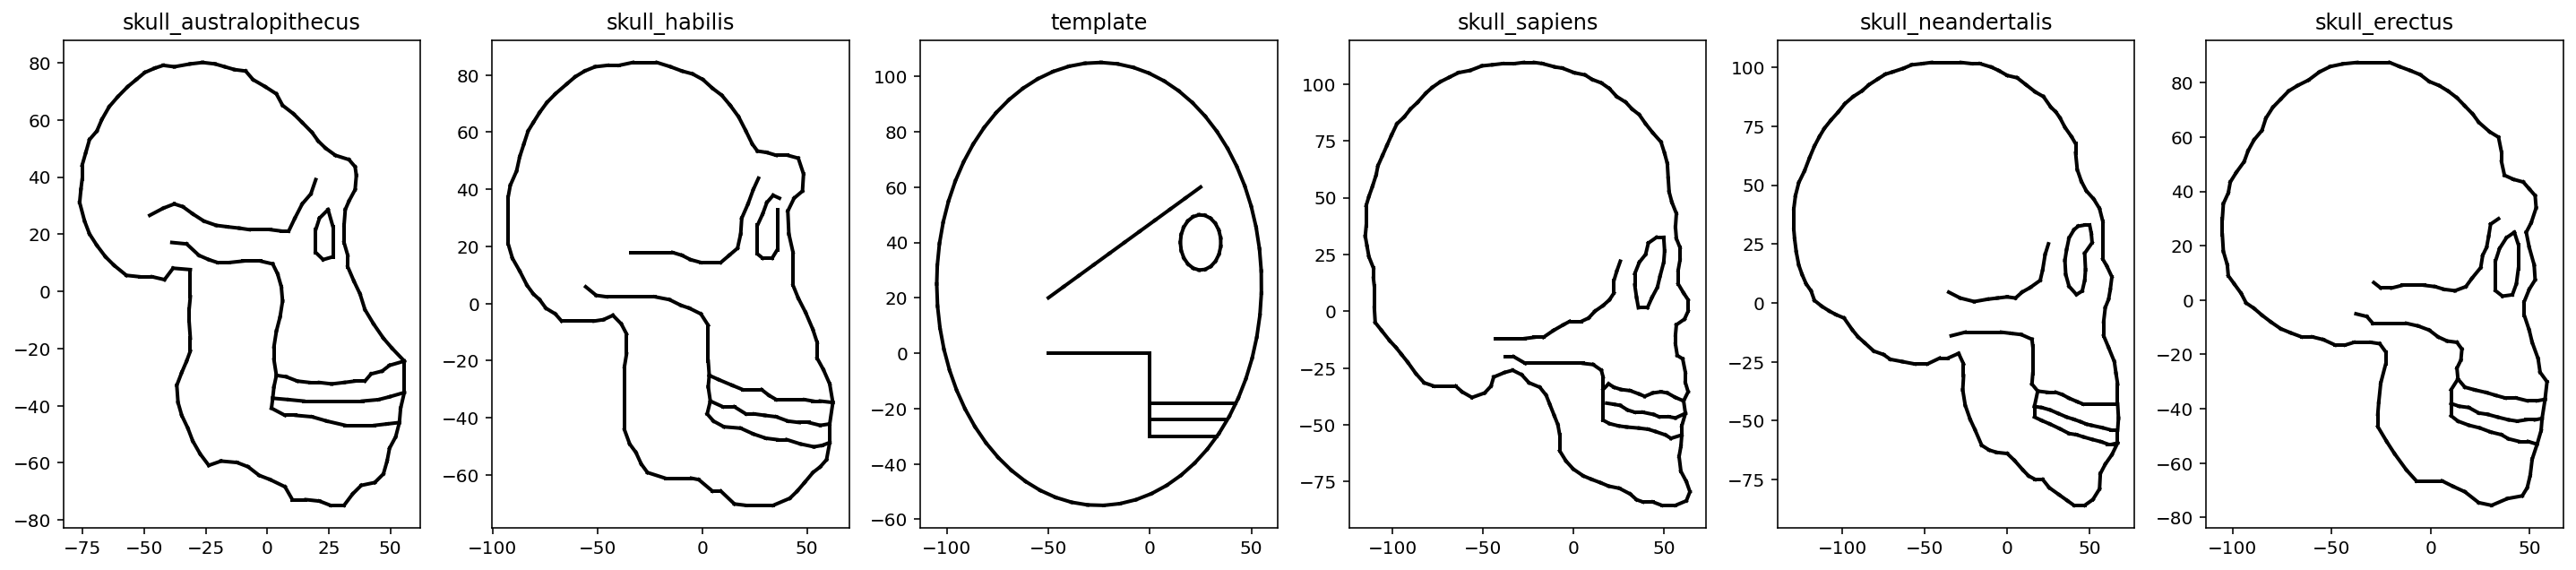

In [7]:
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import deformetrica as dfca

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

data_base = os.path.join(data_path, 'regression/landmark/2d/skulls/data/')


vtk_files = glob.glob(data_base + "*.vtk")

figsize = 5
f = plt.figure(figsize=(5 * figsize, 1 * figsize))
gs = gridspec.GridSpec(1, len(vtk_files))

for i, vtk_file in enumerate(vtk_files):
    ax = plt.subplot(gs[0, i])
    # color = cmap(i % 10)[:3]

    m = re.findall(r".*\/(.*)\..*", vtk_file)
    target_id = m[0]
    target_points__raw, _, target_connectivity__raw = dfca.io.DeformableObjectReader.read_file(vtk_file, extract_connectivity=True)

    p = target_points__raw
    c = target_connectivity__raw
    ax.plot([p[c[:, 0]][:, 0], p[c[:, 1]][:, 0]],
            [p[c[:, 0]][:, 1], p[c[:, 1]][:, 1]],
            'k', linewidth=2)
    ax.set_title(target_id)

plt.style.use('default')
plt.show()

# Import and run Deformetrica

In this cell we will import Deformetrica'api and run a deterministrica atlas on the 2D skulls data located in the `atlas/landmark/2d/skulls/data/` folder.

We will be setting-up an estimator callback to save and later plot the log-likelihood values.

In [8]:
import os
import deformetrica as dfca

data_base = os.path.join(data_path, 'atlas/landmark/2d/skulls/data/')

iteration_status_dictionaries = []

def estimator_callback(status_dict):
    iteration_status_dictionaries.append(status_dict)
    return True

# instantiate a Deformetrica object
deformetrica = dfca.Deformetrica(output_dir='output', verbosity='INFO')

dataset_specifications = {
    'dataset_filenames': [
        [{'skull': os.path.join(data_base, 'skull_australopithecus.vtk')}],
        [{'skull': os.path.join(data_base, 'skull_erectus.vtk')}],
        [{'skull': os.path.join(data_base, 'skull_habilis.vtk')}],
        [{'skull': os.path.join(data_base, 'skull_neandertalis.vtk')}],
        [{'skull': os.path.join(data_base, 'skull_sapiens.vtk')}]],
    'subject_ids': ['australopithecus', 'erectus', 'habilis', 'neandertalis', 'sapiens'],
}
template_specifications = {
    'skull': {'deformable_object_type': 'polyline',
              'kernel_type': 'torch', 'kernel_width': 20.0,
              'noise_std': 1.0,
              'filename': os.path.join(data_base, 'template.vtk'),
              'attachment_type': 'varifold'}
}
estimator_options={'optimization_method_type': 'GradientAscent', 'initial_step_size': 1.,
                   'max_iterations': 25, 'max_line_search_iterations': 10, 'callback': estimator_callback}





# perform a deterministic atlas estimation
model = deformetrica.estimate_deterministic_atlas(template_specifications, dataset_specifications,
                                                estimator_options=estimator_options,
                                                model_options={'deformation_kernel_type': 'torch', 'deformation_kernel_width': 40.0, 'dtype': 'float32'})


Logger has been set to: INFO
>> No initial CP spacing given: using diffeo kernel width of 40.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 4
>> No specified state-file. By default, Deformetrica state will by saved in file: output/deformetrica-state.p.
>> Set of 16 control points defined.
>> Momenta initialized to zero, for 5 subjects.
>> Started estimator: GradientAscent
------------------------------------- Iteration: 0 -------------------------------------
>> Log-likelihood = -1.773E+05 	 [ attachment = -1.773E+05 ; regularity = 0.000E+00 ]
>> Step size and gradient norm: 
		6.227E-05   and   1.606E+04 	[ landmark_points ]
		5.306E-04   and   1.885E+03 	[ momenta ]
------------------------------------- Iteration: 1 -------------------------------------
>> Log-likelihood = -1.748E+05 	 [ attachment = -1.748E+05 ; regularity = -1.706E+00 ]
>> Step size and gradient norm: 
		9.340E-05   and   1.610E+04 	[ landmar

# Plot the log-likelihood

This can be useful to view the estimator's convergence.

dict_keys(['current_iteration', 'current_log_likelihood', 'current_attachment', 'current_regularity', 'gradient'])


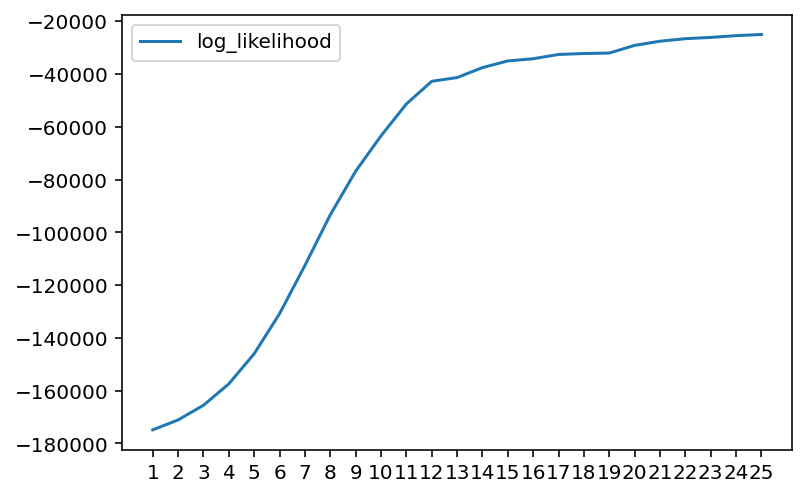

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# print available saved status keys
print(iteration_status_dictionaries[-1].keys())
# print(iteration_status_dictionaries[-1]['gradient'].keys())

x = np.arange(1, estimator_options['max_iterations']+1)

# plot log-likelihood
plt.plot(x, [it_data['current_log_likelihood'] for it_data in iteration_status_dictionaries], label='log_likelihood')
# plt.plot(x, [it_data['current_attachment'] for it_data in iteration_status_dictionaries], label='attachment')
# plt.plot(x, [it_data['current_regularity'] for it_data in iteration_status_dictionaries], label='regularity')

plt.xticks(x)

plt.style.use('default')
plt.legend()
plt.show()

# Plot the resulting templates

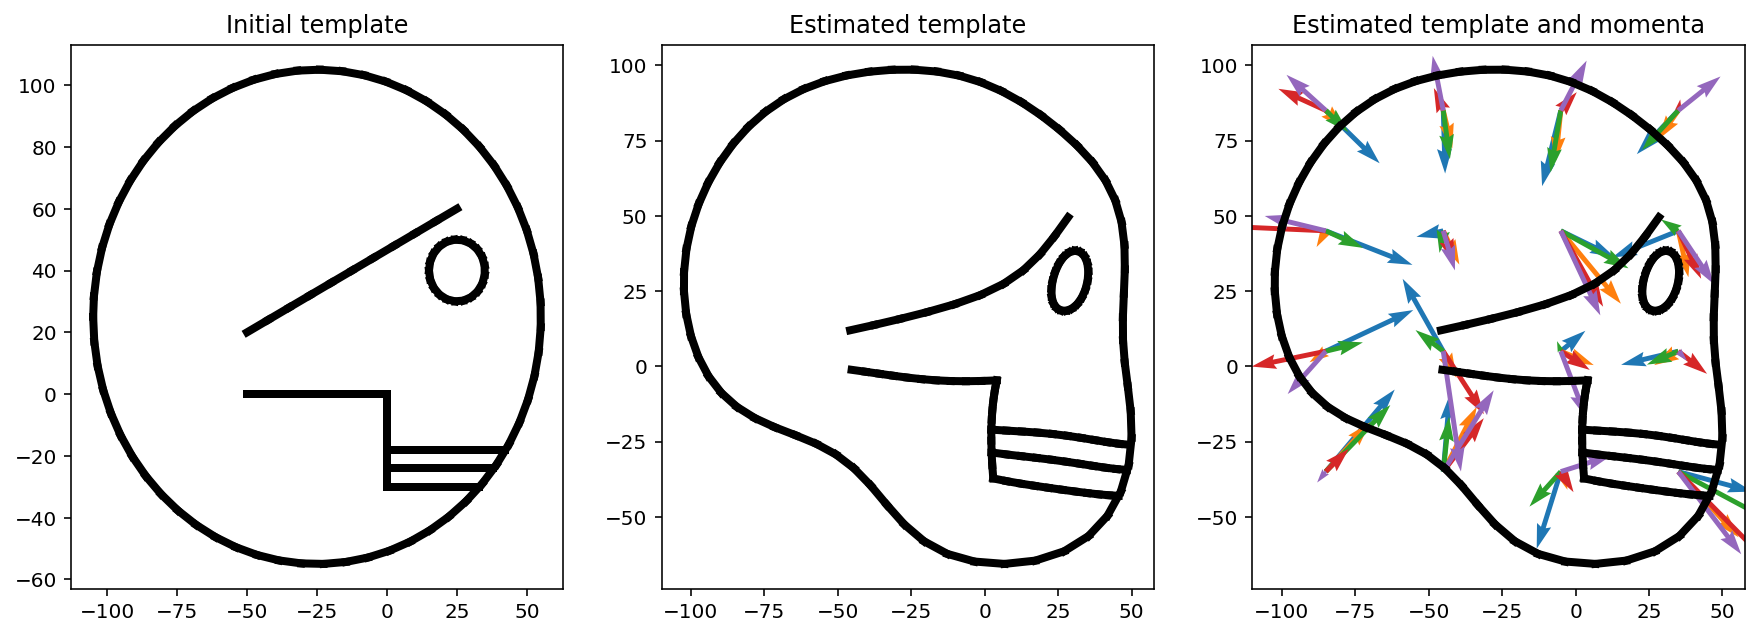

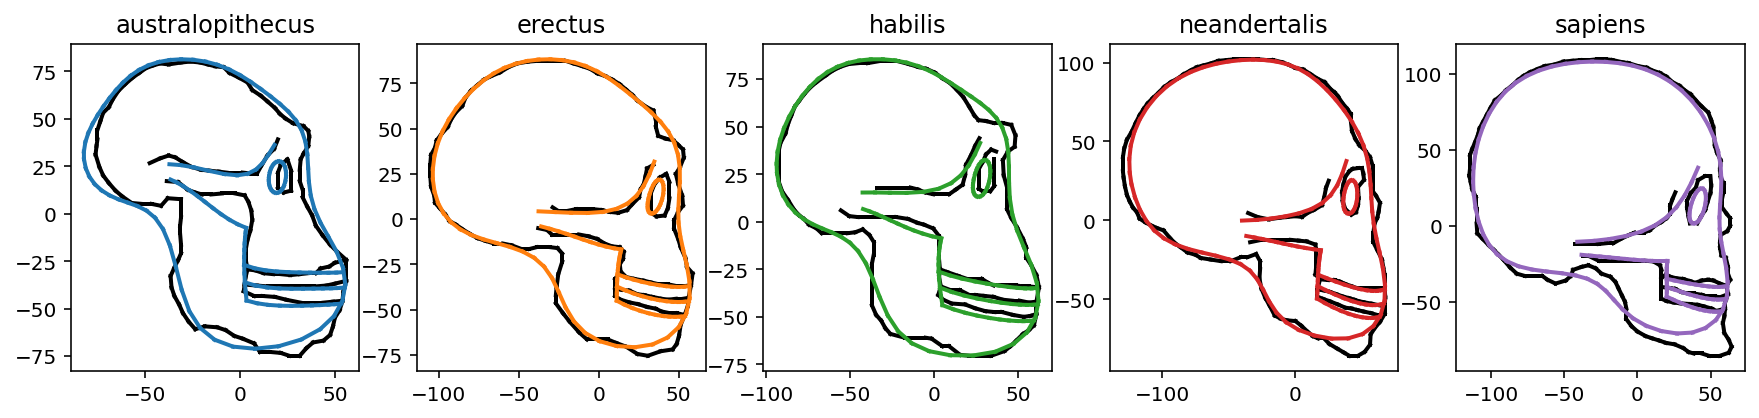

In [10]:
import deformetrica as dfca

path_to_template__ini = template_specifications['skull']['filename']
template_points__ini, dimension, template_connectivity__ini = dfca.io.DeformableObjectReader.read_file(path_to_template__ini, extract_connectivity=True)

fixed_effects = model.fixed_effects

template_points__est = fixed_effects['template_data']['landmark_points']
control_points__est = fixed_effects['control_points']
momenta__est = fixed_effects['momenta']

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

figsize = 5
f = plt.figure(figsize=(3*figsize, 1*figsize))
gs = gridspec.GridSpec(1, 3)

# Initial template
ax = plt.subplot(gs[0, 0])
p = template_points__ini
c = template_connectivity__ini
ax.plot([p[c[:,0]][:,0], p[c[:,1]][:,0]], 
        [p[c[:,0]][:,1], p[c[:,1]][:,1]], 'k', linewidth=4)
ax.set_title('Initial template')

# Estimated template
ax = plt.subplot(gs[0, 1])
p = template_points__est
ax.plot([p[c[:,0]][:,0], p[c[:,1]][:,0]], [p[c[:,0]][:,1], p[c[:,1]][:,1]], 'k', linewidth=4)
ax.set_title('Estimated template')

# Estimated template and momenta
ax = plt.subplot(gs[0, 2])
x = control_points__est
ax.plot([p[c[:,0]][:,0], p[c[:,1]][:,0]], [p[c[:,0]][:,1], p[c[:,1]][:,1]], 'k', linewidth=4)
cmap = cm.get_cmap('tab10')
for i, m in enumerate(momenta__est):
    color = cmap(i % 10)[:3]
    ax.quiver(x[:,0], x[:,1], m[:,0], m[:,1], color=color, width=0.01, scale=75)
ax.set_title('Estimated template and momenta')

####
#### PLOT RAW VERSUS RECONSTRUCTED DATA
####

import torch 

figsize = 3
f = plt.figure(figsize=(5*figsize, 1*figsize))
gs = gridspec.GridSpec(1, 5)

for i, momentum__est in enumerate(momenta__est): 
    ax = plt.subplot(gs[0, i])
    color = cmap(i % 10)[:3]
  
    # Load and plot raw target. 
    path_to_target__raw = dataset_specifications['dataset_filenames'][i][0]['skull']
    target_id = dataset_specifications['subject_ids'][i]
    target_points__raw, _, target_connectivity__raw = dfca.io.DeformableObjectReader.read_file(path_to_target__raw, extract_connectivity=True)

    p = target_points__raw
    c = target_connectivity__raw
    ax.plot([p[c[:,0]][:,0], p[c[:,1]][:,0]], [p[c[:,0]][:,1], p[c[:,1]][:,1]], 'k', linewidth=2)
    ax.set_title(target_id)
  
    # Compute and plot the reconstruction of the target. 
    model.exponential.set_initial_momenta(torch.from_numpy(momentum__est).to(torch.float32))
    model.exponential.update()
    target_points__rec = model.exponential.get_template_points()['landmark_points'].detach().cpu().numpy()
  
    p = target_points__rec
    c = template_connectivity__ini
    ax.plot([p[c[:,0]][:,0], p[c[:,1]][:,0]], [p[c[:,0]][:,1], p[c[:,1]][:,1]], color=color, linewidth=2)

plt.style.use('default')
plt.show()




The previously generated plots, illustrate how an average shape (template) has been computed to fit the input skulls dataset. 


---
You can find out more on:
- the official deformetrica [website](http://www.deformetrica.org)
- the source code [repository](https://gitlab.com/icm-institute/aramislab/deformetrica)
- the documentation [wiki](https://gitlab.com/icm-institute/aramislab/deformetrica/wikis)
- or view and ask questions on the dedicated [Google Groups](https://groups.google.com/forum/?hl=fr#!forum/deformetrica)